****Gathering Data****

In [94]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import requests
import pandas as pd
import math
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import the Twitter archive CSV file into a DataFrame
tweet_df = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
# Download tweet image predictions TSV using the Requests library and write it to image_predictions.tsv
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('image-predictions.tsv', mode='wb') as file:
    file.write(response.content)
    
# Import the tweet image predictions TSV file into a DataFrame
image_df = pd.read_csv('image-predictions.tsv', sep='\t')

In [4]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'GZG3dva0JP479ZQQqlmFmfu10'
consumer_secret = '9hIBaQC9D8oqYYgOb3NYtKfQSF3X8eZXXpDHJWEdnM37nSBxZe'
access_token = '834843246908100609-kKp6ZPJJoeIWl9RMdpYaUQ6QWy3Kr3u'
access_secret = 'vG2zWpjvswDQe1AedAKpPiz7nEX811cqTj7S796qn4nNP'

In [5]:
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [6]:
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [7]:
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = tweet_df.tweet_id.values
len(tweet_ids)

2356

In [8]:
# Using the tweet IDs in the Twitter archive, query the Twitter API for each tweet's JSON

start = timer() # start timer

with open('getstatus_error.txt', 'w') as errfile: 
    valid_ids = 0
    err_ids = 0
    tweet_ids = tweet_df.tweet_id
    with open('tweet_json.txt', 'w', encoding='utf-8') as outfile:
        for i, tweet_id in tweet_ids.iteritems():
            try:
                print("%s# %s" % (str(i+1), tweet_id))
                # Get tweet data using Twitter API
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                json_content = tweet._json
                
                # Write each tweet's JSON data to its own line in a file
                json.dump(json_content, outfile)
                outfile.write('\n')
                valid_ids += 1
            except tweepy.TweepError as e:
                err_ids += 1
                err_str = []
                err_str.append(str(tweet_id))
                err_str.append(': ')
                err_str.append(e.response.json()['errors'][0]['message'])
                err_str.append('\n')
                errfile.write(''.join(err_str))
                print(''.join(err_str))
                continue
        print("%s %s" % ('Valid tweets:', valid_ids))
        print("%s %s" % ('Error tweets:', err_ids))
        
end = timer() # end timer
print((end - start)/(1000*60))

1# 892420643555336193
2# 892177421306343426
3# 891815181378084864
4# 891689557279858688
5# 891327558926688256
6# 891087950875897856
7# 890971913173991426
8# 890729181411237888
9# 890609185150312448
10# 890240255349198849
11# 890006608113172480
12# 889880896479866881
13# 889665388333682689
14# 889638837579907072
15# 889531135344209921
16# 889278841981685760
17# 888917238123831296
18# 888804989199671297
19# 888554962724278272
20# 888202515573088257
888202515573088257: No status found with that ID.

21# 888078434458587136
22# 887705289381826560
23# 887517139158093824
24# 887473957103951883
25# 887343217045368832
26# 887101392804085760
27# 886983233522544640
28# 886736880519319552
29# 886680336477933568
30# 886366144734445568
31# 886267009285017600
32# 886258384151887873
33# 886054160059072513
34# 885984800019947520
35# 885528943205470208
36# 885518971528720385
37# 885311592912609280
38# 885167619883638784
39# 884925521741709313
40# 884876753390489601
41# 884562892145688576
42# 88444180538

In [9]:
# List of dictionaries to read tweet's JSON data line by line and later convert to a DataFrame
df_list = []
with open('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        status = json.loads(line)
        
        # Append to list of dictionaries
        df_list.append({'tweet_id': status['id'],
                        'retweet_count': status['retweet_count'],
                        'favorite_count': status['favorite_count'],
                        'display_text_range': status['display_text_range']
                       })

# Create a DataFrame with tweet ID, retweet count, favorite count and display_text_range
status_df = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count', 'display_text_range'])

**Assessing Data**

In [10]:
# Sampling few data from Twitter archive dataset
tweet_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2251,667806454573760512,NaN,NaN,2015-11-20 20:47:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Filup. He is overcome with joy after f...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667806454...,10,10,Filup,None,None,None,None
1876,675111688094527488,NaN,NaN,2015-12-11 00:35:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Oliver. He thought what was insid...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675111688...,8,10,Oliver,None,None,None,None
1939,673887867907739649,NaN,NaN,2015-12-07 15:32:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're having a great time sleeping and y...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673887867...,10,10,None,None,None,None,None
822,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is just downright precious...,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,https://twitter.com/dog_rates/status/741067306...,12,10,just,doggo,None,pupper,None
2173,669324657376567296,NaN,NaN,2015-11-25 01:20:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Ralf. He's a miniature Buick DiCaprio. Ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669324657...,11,10,Ralf,None,None,None,None


In [11]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

<p>tweet_df (Twitter archive) columns:
 </p>
<li>tweet_id: the unique identifier for each tweet</li>
<li>in_reply_to_status_id: if the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s ID</li>
<li>in_reply_to_user_id: if the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s user ID</li>
<li>timestamp: time when this Tweet was created</li>
<li>source: utility used to post the Tweet, as an HTML-formatted string. e.g. Twitter for Android, Twitter for iPhone, Twitter Web Client</li>
<li>text: actual UTF-8 text of the status update</li>
<li>retweeted_status_id: if the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s ID</li>
<li>retweeted_status_user_id: if the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s author ID</li>
<li>retweeted_status_timestamp: time of retweet</li>
<li>expanded_urls: tweet URL</li>
<li>rating_numerator: numerator of the rating of a dog. Note: ratings almost always greater than 10</li>
<li>rating_denominator: denominator of the rating of a dog. Note: ratings almost always have a denominator of 10</li>
<li>name: name of the dog</li>
<li>doggo: one of the 4 dog "stage"</li>
<li>floofer: one of the 4 dog "stage"</li>
<li>pupper: one of the 4 dog "stage"</li>
<li>puppo: one of the 4 dog "stage"</li>

In [12]:
# Checking if there are any records in tweet_df which are retweets
len(tweet_df[tweet_df.retweeted_status_id.isnull() == False])

181

In [13]:
# Checking if there are any records in tweet_df whose corresponding record with same tweet_id is missing in image_df table
len(tweet_df[~tweet_df.tweet_id.isin(image_df.tweet_id)])

281

In [14]:
# Number of records whose both doggo and floofer columns are not None
len(tweet_df[(tweet_df.doggo != 'None') & (tweet_df.floofer != 'None')])

1

In [15]:
# Number of records whose both doggo and pupper columns are not None
len(tweet_df[(tweet_df.doggo != 'None') & (tweet_df.pupper != 'None')])

12

In [16]:
# Number of records whose both doggo and puppo columns are not None
len(tweet_df[(tweet_df.doggo != 'None') & (tweet_df.puppo != 'None')])

1

In [17]:
# Number of records whose both floofer and pupper columns are not None
len(tweet_df[(tweet_df.floofer != 'None') & (tweet_df.pupper != 'None')])

0

In [18]:
# Number of records whose both floofer and puppo columns are not None
len(tweet_df[(tweet_df.floofer != 'None') & (tweet_df.puppo != 'None')])

0

In [19]:
# Number of records whose both pupper and puppo columns are not None
len(tweet_df[(tweet_df.pupper !='None') & (tweet_df.puppo != 'None')])

0

In [20]:
tweet_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [21]:
#checking for duplicate data on tweet_df
tweet_df.duplicated(subset= None, keep='first').sum()

0

In [22]:
image_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
757,688547210804498433,https://pbs.twimg.com/media/CY42CFWW8AACOwt.jpg,1,papillon,0.531279,True,Blenheim_spaniel,0.214197,True,Border_collie,0.053840,True
1429,772877495989305348,https://pbs.twimg.com/ext_tw_video_thumb/77287...,1,tabby,0.218303,False,Norwegian_elkhound,0.138523,True,wombat,0.074217,False
1552,793150605191548928,https://pbs.twimg.com/media/CwHWOZ7W8AAHv8S.jpg,1,Italian_greyhound,0.193869,True,bluetick,0.160380,True,standard_poodle,0.125982,True
104,667832474953625600,https://pbs.twimg.com/media/CUSeGFNW4AAyyHC.jpg,1,miniature_pinscher,0.214200,True,bath_towel,0.146789,False,Chihuahua,0.104152,True
84,667502640335572993,https://pbs.twimg.com/media/CUNyHTMUYAAQVch.jpg,1,Labrador_retriever,0.996709,True,golden_retriever,0.001688,True,beagle,0.000712,True


In [23]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


image_df (tweet image predictions) columns:<p>
</p>
<li>tweet_id: the unique identifier for each tweet</li>
<li>jpg_url: dog's image URL</li>
<li>img_num: the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images)</li>
<li>p1: algorithm's #1 prediction for the image in the tweet</li>
<li>p1_conf: how confident the algorithm is in its #1 prediction</li>
<li>p1_dog: whether or not the #1 prediction is a breed of dog</li>
<li>p2: algorithm's #2 prediction for the image in the tweet</li>
<li>p2_conf: how confident the algorithm is in its #2 prediction</li>
<li>p2_dog: whether or not the #2 prediction is a breed of dog</li>
<li>p3: algorithm's #3 prediction for the image in the tweet</li>
<li>p3_conf: how confident the algorithm is in its #3 prediction</li>
<li>p3_dog: whether or not the #3 prediction is a breed of dog</li>

In [24]:
##checking for duplicate data on image_df
image_df.duplicated(subset= None, keep='first').sum()

0

In [25]:
status_df.sample(5)

,tweet_id,retweet_count,favorite_count,display_text_range
1324,704859558691414016,573,2336,"[0, 114]"
949,750429297815552001,4581,13766,"[0, 63]"
1041,742150209887731712,1643,5336,"[0, 95]"
1598,685307451701334016,465,2152,"[0, 140]"
528,806542213899489280,2562,10829,"[0, 99]"


In [26]:
status_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 4 columns):
tweet_id              2339 non-null int64
retweet_count         2339 non-null int64
favorite_count        2339 non-null int64
display_text_range    2339 non-null object
dtypes: int64(3), object(1)
memory usage: 73.2+ KB


status_df (tweet status) columns:<p>
</p>
<li>id: the unique identifier for each tweet</li>
<li>retweet_count: number of times this Tweet has been retweeted</li>
<li>favorite_count: indicates approximately how many times this Tweet has been liked by Twitter users</li>
<li>display_text_range: an array of two unicode code point indices, identifying the inclusive start and exclusive end of the displayable content of the Tweet</li>

**Quality**
tweet_df (Twitter archive) table<p>
</p><li>contains retweets and therefore, duplicates</li>
<li>many tweet_id(s) of tweet_df table are missing in image_df (image predictions) table</li>
<li>erroneous datatypes (in_reply_to_status_id, in_reply_to_user_id and timestamp columns)</li>
<li>unnecessary html tags in source column in place of utility name e.g. <a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a></li>
<li>text column contains untruncated text instead of displayable text</li>
<li>erroneous dog names starting with lowercase characters (e.g. a, an, actually, by)</li>
<li>some records have more than one dog stage.</li>

**Tidiness**<p>
</p><li>tweet_df without any duplicates (i.e. retweets) will have empty retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp columns, which can be dropped</li>
<li>doggo, floofer, pupper and puppo columns in tweet_df table should be merged into one column named "stage"</li>
<li>"breed" column should be added in tweet_df table; its values based on p1_conf and p1_dog columns of image_df (image predictions) table</li>
<li>retweet_count and favorite_count columns from status_df (tweet status) table should be joined with tweet_df table</li>

**Cleaning Data**

In [27]:
# copying tweet_df on which the cleaning tasks will be performed
archive_clean = tweet_df.copy()

**Quality**

*tweet_df contains duplicates in form of retweets*

**Define:**<p>
</p>  Remove rows where retweeted_status_id column is not null in tweet_df.

**Code:**

In [28]:
archive_clean = archive_clean[archive_clean.retweeted_status_id.isnull()]

**Test:**

In [29]:
len(archive_clean[archive_clean.retweeted_status_id.isnull() == False])

0

**tweet_df: many tweet_id(s) of tweet_df table are missing in image_df (image predictions) table**

**Define:**<p>
</p>Keep only those records in tweet_df table whose tweet_id exists in image_df table.

**Code:**

In [30]:
archive_clean = archive_clean[archive_clean.tweet_id.isin(image_df.tweet_id)]

**Test:**

In [31]:
len(archive_clean[~archive_clean.tweet_id.isin(image_df.tweet_id)])

0

**tweet_df: erroneous datatypes (in_reply_to_status_id, in_reply_to_user_id and timestamp columns)**

**Define:**<p>
</p>Convert in_reply_to_status_id and in_reply_to_user_id to data type integer and timestamp to datetime datatype

**Code:**

In [32]:
archive_clean.in_reply_to_status_id = archive_clean.in_reply_to_status_id.fillna(0)
archive_clean.in_reply_to_user_id = archive_clean.in_reply_to_user_id.fillna(0)

archive_clean.in_reply_to_status_id = archive_clean.in_reply_to_status_id.astype(np.int64)
archive_clean.in_reply_to_user_id = archive_clean.in_reply_to_user_id.astype(np.int64)

archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)

**Test:**

In [33]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      1994 non-null int64
in_reply_to_status_id         1994 non-null int64
in_reply_to_user_id           1994 non-null int64
timestamp                     1994 non-null datetime64[ns]
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
doggo                         1994 non-null object
floofer                       1994 non-null object
pupper                        1994 non-null object
puppo                         1994 non-null object
dtypes: datetime64[ns](1), flo

**tweet_df: unnecessary html tags in source column in place of utility name e.g. <a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>**

**Define:**<p>
</p>Strip all html anchor tags (i.e. <a..></a>) in source column and retain just the text in between the tags. Later Convert the datatype from string to categorical.

**Code:**

In [34]:
archive_clean.source = archive_clean.source.str.replace(r'<(?:a\b[^>]*>|/a>)', '')

In [35]:
archive_clean.source = archive_clean.source.astype('category')

**Test:**

In [36]:
archive_clean.source.value_counts()

Twitter for iPhone    1955
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

**tweet_df: text column contains untruncated text instead of displayable text**

**Define:**<p>
</p>Using the display_text_range of status_df table, extract displayable text from text column.

**Code:**

In [37]:
# Before extraction: untruncated text of first record
print(archive_clean.iloc[0].text)

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU


In [38]:
# merge status_df's display_text_range column to archive_clean to extract text using range values
archive_clean = pd.merge(archive_clean, status_df[['tweet_id', 'display_text_range']], on='tweet_id')

In [39]:
# using display_text_range of archive_clean, extract displayable text
for i, row in archive_clean.iterrows():
    text_range = row.display_text_range
    display_text = row.text[text_range[0]:text_range[1]]
    archive_clean.set_value(i, 'text', display_text)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


In [40]:
# drop display_text_range column
archive_clean.drop('display_text_range', axis=1, inplace=True)

**Test:**

In [41]:
# After extraction: first record now show displayable text
print(archive_clean.iloc[0].text)

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10


**tweet_df: erroneous dog names starting with lowercase characters (e.g. a, an, actually, by)**

**Define:**<p>
</p>Replace all lowercase values of name column with None

**Code:**

In [42]:
archive_clean['name'][archive_clean['name'].str.match('[a-z]+')] = 'None'

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


**Test:**

archive_clean.name[archive_clean.name == 'None'].value_counts()

**tweet_df: some records have more than one dog stage**

In [43]:
len(archive_clean[(archive_clean.doggo != 'None') & (archive_clean.floofer != 'None')])

1

In [44]:
len(archive_clean[(archive_clean.doggo != 'None') & (archive_clean.puppo != 'None')])

1

In [45]:
len(archive_clean[(archive_clean.doggo != 'None') & (archive_clean.pupper != 'None')])

9

**Define:**<p>
</p>There is one record that has both doggo and floofer and another record that has both doggo and puppo. For these 2 records, take a look at the text manually to decide one dog stage for each of them. For ambiguous texts, set both the column values as None.<p>
There are 9 records which have both doggo and pupper. As per the dogtionary, doggo and pupper are sometimes used interchangeably. Therefore, set pupper column as None for these 9 records.</p>

**Code:**

In [46]:
for i, row in archive_clean[((archive_clean.doggo != 'None') & (archive_clean.floofer != 'None'))
                   | ((archive_clean.doggo != 'None') & (archive_clean.puppo != 'None'))].iterrows():
    print('%s %s\n'%(row.tweet_id, row.text))

855851453814013952 Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for

854010172552949760 At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs



In [47]:
# based on the above texts, doggo should be set as None for both the records
archive_clean['doggo'][archive_clean.tweet_id.isin([855851453814013952, 854010172552949760])] = 'None'

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [48]:
# set pupper column as None for records which have both doggo and pupper
archive_clean['pupper'][(archive_clean.doggo != 'None') & (archive_clean.pupper != 'None')] = 'None'

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


**Test:**

In [49]:
len(archive_clean[((archive_clean.doggo != 'None') & (archive_clean.pupper != 'None'))
                  | ((archive_clean.doggo != 'None') & (archive_clean.floofer != 'None')) 
                  | ((archive_clean.doggo != 'None') & (archive_clean.puppo != 'None'))])

0

**Tidiness**

**tweet_df table without any duplicates (i.e. retweets) have empty retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp columns, which can be dropped**

In [50]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 1990
Data columns (total 17 columns):
tweet_id                      1991 non-null int64
in_reply_to_status_id         1991 non-null int64
in_reply_to_user_id           1991 non-null int64
timestamp                     1991 non-null datetime64[ns]
source                        1991 non-null category
text                          1991 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1991 non-null object
rating_numerator              1991 non-null int64
rating_denominator            1991 non-null int64
name                          1991 non-null object
doggo                         1991 non-null object
floofer                       1991 non-null object
pupper                        1991 non-null object
puppo                         1991 non-null object
dtypes: category(1), datetim

**Define:**

Droping retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp columns from tweet_df table

**Code:**

In [51]:
archive_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

**Test:**

In [52]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 1990
Data columns (total 14 columns):
tweet_id                 1991 non-null int64
in_reply_to_status_id    1991 non-null int64
in_reply_to_user_id      1991 non-null int64
timestamp                1991 non-null datetime64[ns]
source                   1991 non-null category
text                     1991 non-null object
expanded_urls            1991 non-null object
rating_numerator         1991 non-null int64
rating_denominator       1991 non-null int64
name                     1991 non-null object
doggo                    1991 non-null object
floofer                  1991 non-null object
pupper                   1991 non-null object
puppo                    1991 non-null object
dtypes: category(1), datetime64[ns](1), int64(5), object(7)
memory usage: 299.8+ KB


**doggo, floofer, pupper and puppo columns in tweet_df table should be merged into one column named "stage"**

In [53]:
archive_clean.doggo.value_counts()

None     1919
doggo      72
Name: doggo, dtype: int64

In [54]:

archive_clean.floofer.value_counts()

None       1983
floofer       8
Name: floofer, dtype: int64

In [55]:
archive_clean.pupper.value_counts()

None      1788
pupper     203
Name: pupper, dtype: int64

In [56]:
archive_clean.puppo.value_counts()

None     1968
puppo      23
Name: puppo, dtype: int64

**Define:**

Merging the doggo, floofer, pupper and puppo columns to a stage column. Convert the datatype from string to categorical as it helps with analysis.

**Code:**

In [58]:
# merge the doggo, floofer, pupper and puppo columns to a stage column
archive_clean['stage'] = archive_clean[['doggo', 'floofer', 'pupper', 'puppo']].max(axis=1)

In [59]:
#converting stage into catagorical datatype
archive_clean.stage = archive_clean.stage.astype('category')

In [61]:
# drop the doggo, floofer, pupper and puppo columns
archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1,inplace=True)

**Test:**

In [62]:
archive_clean.stage.value_counts()

None       1685
pupper      203
doggo        72
puppo        23
floofer       8
Name: stage, dtype: int64

In [63]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 1990
Data columns (total 11 columns):
tweet_id                 1991 non-null int64
in_reply_to_status_id    1991 non-null int64
in_reply_to_user_id      1991 non-null int64
timestamp                1991 non-null datetime64[ns]
source                   1991 non-null category
text                     1991 non-null object
expanded_urls            1991 non-null object
rating_numerator         1991 non-null int64
rating_denominator       1991 non-null int64
name                     1991 non-null object
stage                    1991 non-null category
dtypes: category(2), datetime64[ns](1), int64(5), object(3)
memory usage: 239.7+ KB


**"breed" column should be added in tweet_df table, its values based on p1_conf and p1_dog columns of image_df table**

**Define:**

Create breed column in tweet_df table. For each tweet_id, use the image_df table to check if p1_conf is greater than 0.95 (i.e. 95% confidence interval) and p1_dog is True. If it is, set the value of p1 column in breed column.

**Code:**

In [64]:
# create breed column
archive_clean['breed'] = 'None'

In [65]:
# iterate through all the rows of archive_clean
for i, row in archive_clean.iterrows():
    image_prediction = image_df[image_df.tweet_id == row.tweet_id]
    p1_conf = image_prediction.p1_conf.iloc[0]
    p1_dog = image_prediction.p1_dog.iloc[0]
    #  check if p1_conf is greater than 0.95 (i.e. 95% confidence interval) and p1_dog is True
    if p1_conf >= 0.95 and p1_dog:
        archive_clean.set_value(i, 'breed', image_prediction.p1.iloc[0])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


**Test:**

In [66]:
archive_clean.breed.value_counts()

None                           1807
pug                              20
Pembroke                         19
Samoyed                          18
golden_retriever                 16
Pomeranian                       13
Chihuahua                         9
French_bulldog                    8
Labrador_retriever                8
chow                              7
Bernese_mountain_dog              4
German_shepherd                   4
Shetland_sheepdog                 4
Blenheim_spaniel                  3
Pekinese                          3
beagle                            3
Old_English_sheepdog              3
dalmatian                         2
Saint_Bernard                     2
Rottweiler                        2
Boston_bull                       2
basset                            2
English_springer                  2
cocker_spaniel                    2
Shih-Tzu                          2
vizsla                            2
bull_mastiff                      2
komondor                    

In [67]:
archive_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,breed
110,865359393868664832,0,0,2017-05-19 00:12:11,Twitter for iPhone,This is Sammy. Her tongue ejects without warni...,https://twitter.com/dog_rates/status/865359393...,13,10,Sammy,None,None
1727,670803562457407488,0,0,2015-11-29 03:16:46,Twitter for iPhone,I would do radical things in the name of Dog G...,https://twitter.com/dog_rates/status/670803562...,10,10,None,None,None
1890,667801013445750784,0,0,2015-11-20 20:25:43,Twitter for iPhone,OMIGOD 12/10 https://t.co/SVMF4Frf1w,https://twitter.com/dog_rates/status/667801013...,12,10,None,None,None
401,806629075125202948,0,0,2016-12-07 22:38:52,Twitter for iPhone,"""Good afternoon class today we're going to lea...",https://twitter.com/dog_rates/status/806629075...,13,10,None,None,None
616,766313316352462849,0,0,2016-08-18 16:38:26,Twitter for iPhone,This is Oscar. He has legendary eyebrows and h...,https://twitter.com/dog_rates/status/766313316...,12,10,Oscar,None,toy_poodle


**retweet_count and favorite_count columns from status_df table should be joined with tweet_df table**

**Define:**

Create retweet_count and favorite_count columns in tweet_df table. For each tweet_id, fetch the retweet_count and favorite_count columns of status_df table and assign those values to tweet_df table.

**Code:**

In [68]:
# create retweet_count and favorite_count columns
archive_clean['retweet_count'] = 0
archive_clean['favorite_count'] = 0

In [69]:
# iterate through all the rows of archive_clean
for i, row in archive_clean.iterrows():
    # fetch the retweet_count and favorite_count columns of status_df table and assign those values
    archive_clean.set_value(i, 'retweet_count', status_df[status_df.tweet_id == row.tweet_id].retweet_count.iloc[0])
    archive_clean.set_value(i, 'favorite_count', status_df[status_df.tweet_id == row.tweet_id].favorite_count.iloc[0]) 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


**Test:**

In [70]:
archive_clean[['tweet_id', 'retweet_count', 'favorite_count']].sample(5)

,tweet_id,retweet_count,favorite_count
1552,674447403907457024,365,1080
1149,695074328191332352,1167,2955
1706,671151324042559489,158,671
1369,680609293079592961,751,2736
747,747600769478692864,583,2418


**Storing the Data:**

In [71]:
archive_clean.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

**Analyzing the data:**

In [72]:
# For analysis, create a copy of the cleaned twitter archive data
df = archive_clean.copy()

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 1990
Data columns (total 14 columns):
tweet_id                 1991 non-null int64
in_reply_to_status_id    1991 non-null int64
in_reply_to_user_id      1991 non-null int64
timestamp                1991 non-null datetime64[ns]
source                   1991 non-null category
text                     1991 non-null object
expanded_urls            1991 non-null object
rating_numerator         1991 non-null int64
rating_denominator       1991 non-null int64
name                     1991 non-null object
stage                    1991 non-null category
breed                    1991 non-null object
retweet_count            1991 non-null int64
favorite_count           1991 non-null int64
dtypes: category(2), datetime64[ns](1), int64(7), object(4)
memory usage: 206.4+ KB


**Finding out the most common source**

In [74]:
df.source.value_counts()

Twitter for iPhone    1953
Twitter Web Client      28
TweetDeck               10
Name: source, dtype: int64

**Image prediction analysis**

In [80]:
df['breed'][df['breed'] == 'None'].value_counts()

None    1807
Name: breed, dtype: int64

The breed of 1808 dogs out of 1991 (i.e. 92%) couldn't be predicted. So, at 95% confidence interval, the image prediction algorithm was able to predict the breed for 9.2% of the dog population of this data set.

**Average of retweets and favourite counts**

In [82]:
print('Mean retweet count: ', df.retweet_count.mean())
print('Mean favorite count: ', df.favorite_count.mean())

Mean retweet count:  2621.41034656
Mean favorite count:  8642.34605726


**Average of retweets and favourite counts when the dog is rated greater than 10**

In [90]:
print('Mean Retweet Count: ', df.retweet_count[df.rating_numerator > 10].mean())
print('Mean Favorite Count: ', df.favorite_count[df.rating_numerator > 10].mean())

Mean Retweet Count:  3646.34081104
Mean Favorite Count:  12444.2148404


**Average of retweets and favourite counts when the dog has a name**

In [91]:
print('Mean Retweet Count', df.retweet_count[df.name != 'None'].mean())
print('Mean Favorite Count: ', df.favorite_count[df.name != 'None'].mean())

Mean Retweet Count 2581.10838901
Mean Favorite Count:  9031.08760208


**Average of retweets and favourite counts categorized by dog-stage**

In [93]:
print('Doggo')
print('Mean Retweet Count: ', df.retweet_count[df.stage == 'doggo'].mean())
print('Mean Favorite Count: ', df.favorite_count[df.stage == 'doggo'].mean())
print('Floofer')
print('Mean Retweet Count: ', df.retweet_count[df.stage == 'floofer'].mean())
print('Mean Favorite Count: ', df.favorite_count[df.stage == 'floofer'].mean())
print('Pupper')
print('Mean Retweet Count: ', df.retweet_count[df.stage == 'pupper'].mean())
print('Mean Favorite Count: ', df.favorite_count[df.stage == 'pupper'].mean())
print('Puppo')
print('Mean Retweet Count: ', df.retweet_count[df.stage == 'puppo'].mean())
print('Mean Favorite Count: ', df.favorite_count[df.stage == 'puppo'].mean())

Doggo
Mean Retweet Count:  6614.44444444
Mean Favorite Count:  19029.9027778
Floofer
Mean Retweet Count:  4460.875
Mean Favorite Count:  13039.75
Pupper
Mean Retweet Count:  2224.26600985
Mean Favorite Count:  6942.34482759
Puppo
Mean Retweet Count:  6732.65217391
Mean Favorite Count:  22654.173913


**Number of tweets posted by WeRateDogs' over time**

In [89]:
df['timestamp'].apply(lambda x: x.strftime('%Y-%m')).value_counts()
# here strftime() is used to convert datetime to string.

2015-12    366
2015-11    296
2016-01    169
2016-03    120
2016-02    111
2016-07     87
2016-06     81
2017-01     66
2016-10     65
2017-02     64
2016-09     63
2016-08     59
2016-05     57
2016-12     54
2016-04     54
2016-11     53
2017-07     49
2017-03     48
2017-05     43
2017-06     43
2017-04     41
2017-08      2
Name: timestamp, dtype: int64

**Visalization:**

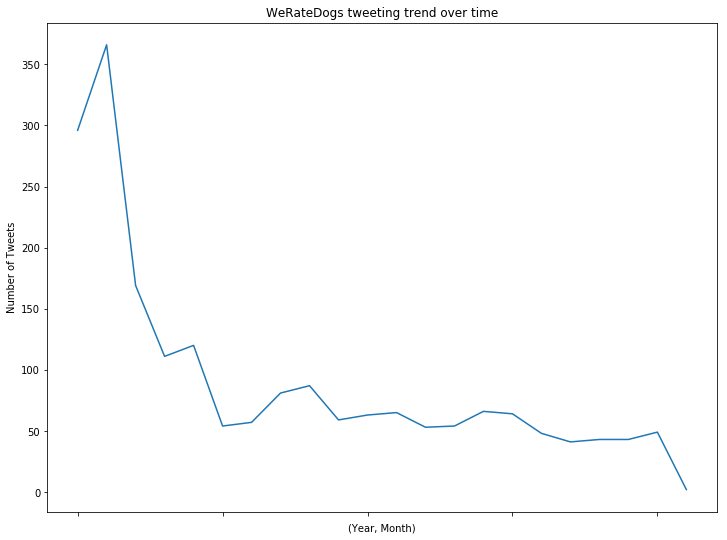

In [107]:
d = df.tweet_id.groupby([df["timestamp"].dt.year, df["timestamp"].dt.month]).count() 
#count tweets 
a = d.plot('line', title='WeRateDogs tweeting trend over time', figsize=(12, 9))
a.set_xlabel("(Year, Month)")
a.set_ylabel("Number of Tweets")
plt.savefig('tweet_trend')

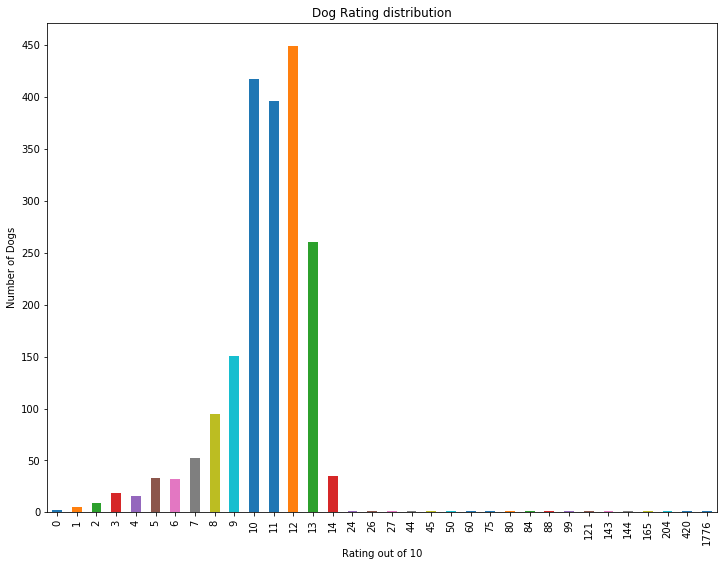

In [109]:
ax = df.rating_numerator.value_counts().sort_index().plot('bar', title = 'Dog Rating distribution', 
                                                         figsize = (12,9))
ax.set_xlabel("Rating out of 10")
ax.set_ylabel("Number of Dogs")
ax.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450])
plt.savefig('rating_dist')

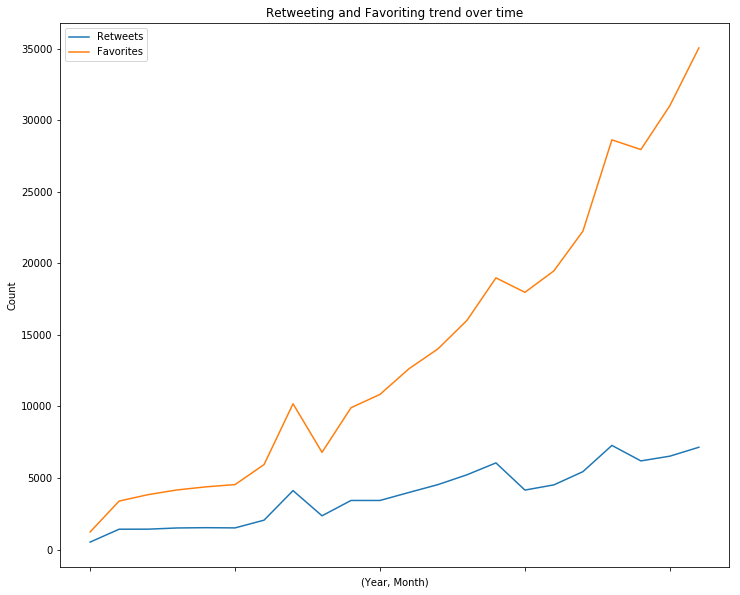

In [111]:
df.retweet_count.groupby([df["timestamp"].dt.year, df["timestamp"].dt.month]).mean().plot(('line'), figsize = (12,10))
df.favorite_count.groupby([df["timestamp"].dt.year, df["timestamp"].dt.month]).mean().plot(('line'), figsize = (12,10))
plt.title('Retweeting and Favoriting trend over time')
plt.ylabel('Count')
plt.xlabel('(Year, Month)')
plt.legend(('Retweets', 'Favorites'))
plt.savefig('ret_fav')

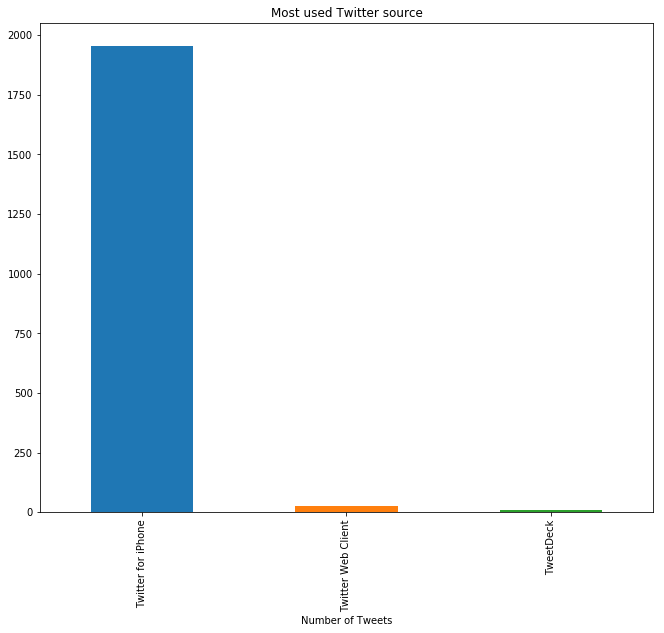

In [116]:
df['source'].value_counts().plot('bar', figsize=(11,9), title='Most used Twitter source').set_xlabel("Number of Tweets")
plt.savefig('twitter_source')

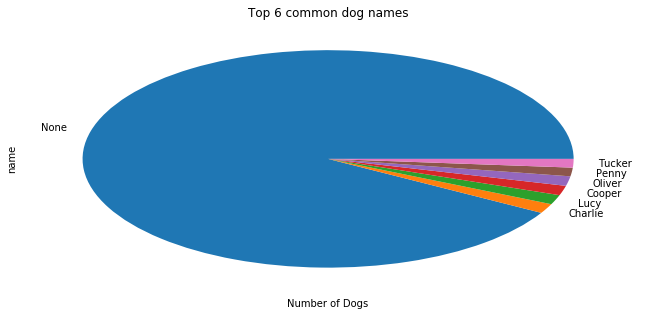

In [118]:
df.name.value_counts()[:7].plot('pie', figsize=(11,5), title='Top 6 common dog names').set_xlabel("Number of Dogs")
plt.savefig('dog_names')